In [ ]:
# script to download mistral LLM

In [1]:
import os
import json
from huggingface_hub import hf_hub_download
from concurrent.futures import ThreadPoolExecutor, as_completed
from google.colab import userdata

In [2]:
MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.2"
LOCAL_DIR = "models/Mistral-7B-Instruct-v0.2"
os.makedirs(LOCAL_DIR, exist_ok=True)

In [3]:
TOKEN = userdata.get('HF_TOKEN')

In [4]:
# Function to download shards
def download_shard(shard_name):
    print(f"Downloading shard {shard_name}…")
    hf_hub_download(
        repo_id=MODEL_ID,
        filename=shard_name,
        local_dir=LOCAL_DIR,
        use_auth_token=TOKEN,
        local_files_only=False
    )
    return shard_name

In [5]:
# Function to download model
def download_model():
    # Download index files
    for fname in [
        "config.json",
        "generation_config.json",
        "model.safetensors.index.json",
        "pytorch_model.bin.index.json",
        "tokenizer.json",
        "tokenizer_config.json",
        "special_tokens_map.json",
    ]:
        print(f"Downloading {fname}…")
        hf_hub_download(
            repo_id=MODEL_ID,
            filename=fname,
            local_dir=LOCAL_DIR,
            use_auth_token=TOKEN,
            local_files_only=False
        )

    # Read safetensors index and schedule each shard
    with open(os.path.join(LOCAL_DIR, "model.safetensors.index.json")) as f:
        st_index = json.load(f)
    safetensor_shards = list(set(st_index["weight_map"].values()))

    # Read bin index and schedule each shard (optional; skip if you only want safetensors)
    with open(os.path.join(LOCAL_DIR, "pytorch_model.bin.index.json")) as f:
        bin_index = json.load(f)
    bin_shards = list(set(bin_index["weight_map"].values()))

    # Combine them or pick one format:
    # To download only safetensors, use safetensor_shards.
    # To download only bin, use bin_shards.
    shards = safetensor_shards  # or bin_shards

    with ThreadPoolExecutor(max_workers=6) as exe:
        futures = [exe.submit(download_shard, s) for s in shards]
        for fut in as_completed(futures):
            print("Finished:", fut.result())
    print("All shards downloaded!")

In [6]:
download_model()

config.json:   0%|          | 0.00/596 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.94G [00:00<?, ?B/s]

Finished: model-00003-of-00003.safetensors
Finished: model-00001-of-00003.safetensors
Finished: model-00002-of-00003.safetensors
All shards downloaded!


In [ ]:
# Training!

In [ ]:
import argparse
import os
import torch
import pandas as pd
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
from peft import LoraConfig, get_peft_model

In [ ]:
base_model="models/Mistral-7B-Instruct-v0.2"

In [ ]:
OUTPUT_DIR = "healthver-sft"
SEQ_LEN    = 400
#clone & load CSVs
if not os.path.isdir("HealthVer"):
    os.system("git clone https://github.com/sarrouti/HealthVer.git")
train_df = pd.read_csv("HealthVer/data/healthver_train.csv")
val_df   = pd.read_csv("HealthVer/data/healthver_dev.csv")
train_ds = Dataset.from_pandas(train_df)
val_ds   = Dataset.from_pandas(val_df)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
        base_model,
        use_fast=True,
        offload_state_dict=True
    )
tokenizer.model_max_length = SEQ_LEN
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

In [ ]:
def preprocess(ex):
    prompt = (
        "Evidence:\n" + ex["evidence"]
        + f"\n\nClaim: {ex['claim']}\nQuestion: {ex['question']}"
    )
    response = ex["label"]
    text = prompt + "\n### Response: " + response
    return tokenizer(text, truncation=True, max_length=SEQ_LEN)


In [ ]:
train_tok = train_ds.map(preprocess, remove_columns=train_ds.column_names)
val_tok   = val_ds.map(preprocess,   remove_columns=val_ds.column_names)


Map:   0%|          | 0/10590 [00:00<?, ? examples/s]

Map:   0%|          | 0/1917 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16,
    offload_state_dict=True
)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.half().to(device)

In [ ]:
for p in model.parameters():
        p.requires_grad = False

In [ ]:
lora_cfg = LoraConfig(
        r=8,
        lora_alpha=16,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.05,
        bias="none",
        task_type="CAUSAL_LM",
    )
model = get_peft_model(model, lora_cfg)
model.config.use_cache = False

In [ ]:
model.config.label_names = ["labels"]

In [ ]:
for n, p in model.named_parameters():
        if "lora" in n:
            assert p.requires_grad
        else:
            assert not p.requires_grad

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)
training_args = TrainingArguments(
        output_dir=OUTPUT_DIR,
        overwrite_output_dir=True,
        do_eval=True,
        eval_steps=500,
        save_steps=500,
        logging_steps=100,
        per_device_train_batch_size=2,
        per_device_eval_batch_size=2,
        num_train_epochs=3,
        fp16=torch.cuda.is_available(),
        learning_rate=2e-5,
        warmup_steps=100,
        save_total_limit=2,
        report_to=[],  # disable wandb
    )
trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tok,
        eval_dataset=val_tok,
        data_collator=data_collator,
    )

No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:
trainer.train()

Step,Training Loss
100,2.621800
200,1.772600
300,1.640600
400,1.593900
500,1.581600
600,1.506700
700,1.451700
800,1.453200
900,1.413000
1000,1.359700


Step,Training Loss
100,2.621800
200,1.772600
300,1.640600
400,1.593900
500,1.581600
600,1.506700
700,1.451700
800,1.453200
900,1.413000
1000,1.359700


TrainOutput(global_step=15885, training_loss=0.7242550781173154, metrics={'train_runtime': 6256.8806, 'train_samples_per_second': 5.078, 'train_steps_per_second': 2.539, 'total_flos': 1.8070640393792717e+17, 'train_loss': 0.7242550781173154, 'epoch': 3.0})

In [ ]:
from google.colab import drive
import os

# 1) Mount Drive (you'll get a link to authorize)
drive.mount('/content/drive')

# 2) Choose an output path in your Drive
OUTPUT_DIR = '/content/drive/MyDrive/healthver_sft'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 3) After training finishes:
model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Saved LoRA adapters and tokenizer to {OUTPUT_DIR}")


Mounted at /content/drive
Saved LoRA adapters and tokenizer to /content/drive/MyDrive/healthver_sft


In [ ]:
# KG Creation

In [8]:
!pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 25.4 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline
import pandas as pd, json
from neo4j import GraphDatabase


In [ ]:
extractor = pipeline(
  "text-generation",
  model=model,
  tokenizer=tokenizer,
  device=0,
  return_full_text=False
)
IE_PROMPT = """You are an information extraction model for biomedical research abstracts.
Extract complete triplets of the form:
  - object: biomedical noun phrase
  - subject: biomedical noun phrase
  - predicate: short relation verb or verb phrase

Respond with ONLY valid JSON like this:

{
  "triplets": [
    {"object": "headache", "subject": "aspirin", "predicate": "treats"},
    {"object": "COVID-19",   "subject": "vaccine", "predicate": "prevents"}
  ]
}

Rules:
•⁠  ⁠Each triplet MUST contain all 3 fields: object, subject, predicate.
•⁠  ⁠Do not return any nulls or missing fields.
•⁠  ⁠Use clear biomedical nouns or noun phrases for object.
•⁠  ⁠Do not include explanation, markdown, or natural language text.
"""

Device set to use cuda:0


In [ ]:
import re
df = pd.read_csv("https://raw.githubusercontent.com/sarrouti/HealthVer/master/data/healthver_dev.csv")

In [ ]:
for i, row in df.iterrows():
    inp = IE_PROMPT + "\n\nText: " + row['evidence']
    raw = extractor(inp, max_new_tokens=1000, do_sample=False)[0]['generated_text']
    print(raw)
    try:
      match = re.search(r'\{.*"triplets"\s*:\s*\[.*?\]\s*\}', raw, re.DOTALL)
      if not match:
          raise ValueError("No valid triplets JSON block found.")
      data = json.loads(match.group(0)) # {"triplets":[{...},...]}
    except Exception as e:
      print(e)
      data = {"triplets":[]}
    df.at[i, 'triplets'] = data['triplets']

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


 The causative agent is a novel coronavirus, SARS-CoV-2. The disease is called Covid19. The symptoms include fever, cough, and shortness of breath. The disease is transmitted via respiratory droplets. The infection can lead to pneumonia, severe acute respiratory syndrome, kidney failure, and even death.

There are several vaccines that have been developed to prevent Covid19. The Pfizer-BioNTech vaccine, Moderna vaccine, and AstraZeneca vaccine are some of the most widely used vaccines. The vaccines work by teaching the immune system to recognize and fight the virus. The vaccines have been shown to be highly effective in preventing Covid19 infection and severe disease.

Aspirin is a nonsteroidal anti-inflammatory drug (NSAID) that is commonly used to treat pain, fever, and inflammation. It is often used to treat headaches, menstrual cramps, and arthritis. Aspirin can also be used to prevent heart attacks and strokes by reducing the risk of blood clots.

{
  "triplets": [
    {"object": 

In [ ]:
# ——————————————————————————
uri      = 'bolt://3.86.101.25'
username = 'neo4j'
password = 'solders-alibi-prepositions'
driver   = GraphDatabase.driver(uri, auth=(username, password))

# Write both subgraphs in one batch
with driver.session(database="neo4j") as session:
    # Merge Claim/Evidence nodes + labeled edges
    session.run(
        """
        UNWIND $dev AS row
          MERGE (c:Claim    {id: row.claim_id})    SET c.text = row.claim
          MERGE (e:Evidence {id: row.evidence_id}) SET e.text = row.evidence
          FOREACH (_ IN CASE WHEN row.label='SUPPORTS'        THEN [1] ELSE [] END |
            MERGE (c)-[:SUPPORTS]->(e))
          FOREACH (_ IN CASE WHEN row.label='REFUTES'         THEN [1] ELSE [] END |
            MERGE (c)-[:REFUTES]->(e))
          FOREACH (_ IN CASE WHEN row.label='NOT_ENOUGH_INFO' THEN [1] ELSE [] END |
            MERGE (c)-[:NOT_ENOUGH_INFO]->(e))
        """,
        dev=df.to_dict('records')
    )

    # 4b) Merge Entity/Entity nodes + dynamic triplet edges
    for t in df['triplets']:
        subj = t["subject"]
        obj  = t["object"]
        pred = (t.get("predicate") or "").strip()
        if not pred:
            continue
        # sanitize label
        lbl = re.sub(r'\W+', '_', pred).strip('_').upper()
        lbl = lbl or "RELATION"
        # execute one MERGE per triplet
        session.run(
            f"""
            MERGE (s:Entity {{name:$subj}})
            MERGE (o:Entity {{name:$obj}})
            MERGE (s)-[:`{lbl}`]->(o)
            """,
            subj=subj, obj=obj
        )

driver.close()

In [ ]:
# import json
# from typing import List, Tuple

# with open("triplets.json", "r") as f:
#     _KG_DUMP = json.load(f)

# # Sanity check
# print("Top‐level keys:", _KG_DUMP.keys())

# # Build a flat list of (subject, predicate, object) tuples
# _all_triplets: List[Tuple[str,str,str]] = [
#     (t["subject"], t["predicate"], t["object"])
#     for t in _KG_DUMP.get("triplets", [])
# ]

# print(f"🔍 Loaded {_all_triplets!r} (showing first 5):\n", _all_triplets[:5])

# def get_triples_for_claim(claim: str, limit: int = 20) -> List[Tuple[str,str,str]]:
#     """
#     Since this JSON is for one claim only, we ignore `claim` and just
#     return up to `limit` of the precomputed triples.
#     """
#     return _all_triplets[:limit]

In [ ]:
#### KG Retrieval

In [1]:
!pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.3/312.3 kB 4.9 MB/s eta 0:00:00


In [2]:
from neo4j import GraphDatabase
import os
from typing import List, Tuple

# Connection settings
os.environ['NEO4J_URI']      = 'bolt://3.86.101.25'
os.environ['NEO4J_USERNAME'] = 'neo4j'
os.environ['NEO4J_PASSWORD'] = 'solders-alibi-prepositions'
os.environ['NEO4J_DATABASE'] = 'neo4j'

driver = GraphDatabase.driver(
    os.environ['NEO4J_URI'],
    auth=(os.environ['NEO4J_USERNAME'], os.environ['NEO4J_PASSWORD'])
)

# --- Placeholder entity extractor (replace with NLP method like scispacy, MetaMap, etc.)
def _extract_entities(text: str) -> List[str]:
    # Simplified: split by space and remove punctuation
    import re
    tokens = re.findall(r'\b\w+\b', text)
    return [t for t in tokens if len(t) > 3]  # Filter short/common words

# --- Triplet retriever based on fuzzy match with entities from claim
def get_triples_by_entity_similarity(claim: str, limit: int = 20) -> List[Tuple[str, str, str]]:
    ents = _extract_entities(claim)
    if not ents:
        return []

    ents_low = [e.lower() for e in ents]

    cypher = """
    UNWIND $ents AS term
    MATCH (s)-[r]->(o)
    WHERE toLower(s.name) CONTAINS term
       OR term CONTAINS toLower(s.name)
       OR toLower(o.name) CONTAINS term
       OR term CONTAINS toLower(o.name)
    RETURN DISTINCT s.name AS subject,
                    type(r) AS predicate,
                    o.name AS object
    LIMIT $limit
    """

    with driver.session(database=os.environ['NEO4J_DATABASE']) as session:
        res = session.run(cypher, {"ents": ents_low, "limit": limit})
        return [(row["subject"], row["predicate"], row["object"]) for row in res]


In [ ]:
#### PUBMED RETRIEVAL

In [3]:
!pip install rank_bm25
!pip install scispacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.2/920.2 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 29.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: blis
    Found existing installation: blis 1.3.0
    Uninstalling blis-1.3.0:
      Successfully uninstalled blis-1.

In [4]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_core_sci_lg-0.5.4.tar.gz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.2/531.2 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_sci_lg: filename=en_core_sci_lg-0.5.4-py3-none-any.whl size=531476533 sha256=68fb70f4de82155f5a0ee398f25578982a86e2fc70caaba87ae08bd1bafe9d26
  Stored in directory: /root/.cache/pip/wheels/d6/b1/2f/ce1b43e2194a41a5c93baa170fd8cb638e4938a068a7190068
Successfully built en_core_sci_lg


In [5]:
!pip install -U spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 97.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 114.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: blis
    Found existing installation: blis 0.7.11
    Uninstalling blis-0.7.11:
      Successfully uninstalled blis-0.7.11
  Attempting uninstall: thinc
    Found existing installation: thinc 8.2.5
    Uninstalling thinc-8.2.5:
      Successfully uninstalled thinc-8.2.5
  Attempting uninstall: spacy
    Found existing installation: spacy 3.7.5
    Uninstalling spacy-3.7.5:
      Successfully uninstalled spacy-3.7.5
ERROR: pip'

In [6]:
import os
import re
import requests
import xml.etree.ElementTree as ET
from functools import lru_cache
from typing import List, Dict
from rank_bm25 import BM25Okapi
import spacy

In [8]:
# Configure your email and (optionally) API key in your Colab environment:
#   %env ENTREZ_EMAIL=your_email@example.com
ENTREZ_EMAIL = os.getenv("ENTREZ_EMAIL", "amintarebecca.ar@gmail.com")
ENTREZ_KEY   = os.getenv("ENTREZ_KEY",   "eabfe9be67edd16a3f6f3bfedd0924ce2509")
NCBI_BASE    = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils"

# load the SciSpaCy model once
_nlp = spacy.load("en_core_sci_lg")

_EN_STOP = {
    "a","an","the","of","to","and","in","on","for","with","into","from","by",
    "about","is","are","was","were","be","been","being","as","that","this",
    "these","those","it","its","their","at","or","not","but","than","then",
}

/usr/local/lib/python3.11/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_sci_lg' (0.5.4) was trained with spaCy v3.7.4 and may not be 100% compatible with the current version (3.8.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/usr/local/lib/python3.11/dist-packages/spacy/language.py:2232: FutureWarning: Possible set union at position 6328
  deserializers["tokenizer"] = lambda p: self.tokenizer.from_disk(  # type: ignore[union-attr]


In [23]:
def _tokenise(text: str) -> List[str]:
    """Lower-case, strip punctuation, remove trivial stop-words."""
    words = re.findall(r"[A-Za-z0-9-]+", text.lower())
    return [w for w in words if w not in _EN_STOP and len(w) > 2]

def _extract_bio_entities(text: str) -> set:
    """Use SciSpaCy to pull out biomedical named entities (lemmas)."""
    doc = _nlp(text)
    return {ent.lemma_.lower() for ent in doc.ents}

@lru_cache(maxsize=1024)
def _mesh_synonyms(term: str) -> List[str]:
    """
    Use PubMed’s automatic term‐mapping to find MeSH synonyms for a single token.
    """
    try:
        resp = requests.get(
            f"{NCBI_BASE}/esearch.fcgi",
            params={"db":"pubmed","term":term,"retmode":"json","retmax":0},
            timeout=6
        )
        resp.raise_for_status()
        stack = resp.json()["esearchresult"].get("translationstack", [])
        mesh_terms = set()
        def _collect(e):
            if isinstance(e, dict) and e.get("Field","").lower()=="mesh terms":
                txt = e["term"]
            elif isinstance(e, str) and e.endswith("[MeSH Terms]"):
                txt = e
            else:
                return
            cleaned = re.sub(r'\[.*\]$',"", txt).strip('"').lower()
            if cleaned and cleaned != term.lower():
                mesh_terms.add(cleaned)
        for elem in stack:
            if isinstance(elem, list):
                for sub in elem:
                    _collect(sub)
            else:
                _collect(elem)
        return sorted(mesh_terms)
    except Exception:
        return []

def _build_pubmed_query(claim: str, verbose: bool = True) -> str:
    """
    Tokenise the claim → extract biomedical entities → only MeSH‐expand
    those entities → fallback on entity tokens via [TIAB] → if no entities,
    fallback on all tokens via [TIAB].
    """
    toks     = _tokenise(claim)
    entities = _extract_bio_entities(claim)

    mesh_chunks = []
    fallback    = []

    if verbose:
        print("\n[Bio‐entities found]")
        print(" ", entities)

    # 1) only consider entity tokens for MeSH
    if verbose:
        print("toks:", toks)
    for t in toks:
        if t not in entities:
            continue

        syns = _mesh_synonyms(t)
        if syns:
            if verbose:
                print(f"  {t:>12} → {', '.join(syns)}")
            mesh_chunks += [f'"{s}"[MeSH Terms]' for s in syns]
        else:
            # no MeSH found, but t is a bio‐entity → fallback to TIAB
            fallback.append(f"{t}[TIAB]")

    all_terms = mesh_chunks + fallback
    if verbose:
        print("all_terms:", all_terms)
        print("entities:", entities)

    # for entity in entities:
    #     term = f"{entity}[TIAB]"
    #     if entity not in all_terms and term not in all_terms:
    #         fallback.append(term)
    # 2) if there were *no* entity tokens at all, fallback on all toks
    if not entities:
        if verbose:
            print("No bio‐entities found; falling back to all tokens as [TIAB].")
        fallback = [f"{w}[TIAB]" for w in toks]
    if verbose:
      print("\n→ Final MeSH chunks:\n  ", " OR ".join(mesh_chunks), "\n")
    query = " OR ".join(mesh_chunks + fallback)

    if verbose:
        print("\n→ Final PubMed query:\n  ", query, "\n")
    return query

def _search_pubmed(term: str, retmax: int = 100) -> List[str]:
    """eSearch → list of PMIDs."""
    params = {
        "db":"pubmed","term":term,
        "retmode":"json","retmax":retmax,
        **({"api_key":ENTREZ_KEY} if ENTREZ_KEY else {}),
        "email":ENTREZ_EMAIL,
    }
    r = requests.get(f"{NCBI_BASE}/esearch.fcgi", params=params, timeout=10)
    r.raise_for_status()
    return r.json()["esearchresult"].get("idlist", [])

def _fetch_abstracts(pmids: List[str]) -> Dict[str,str]:
    """Fetch title + abstract for every PMID in one go, robust to missing AbstractText."""
    if not pmids:
        return {}
    params = {
        "db":"pubmed",
        "id":",".join(pmids),
        "retmode":"xml",
        "rettype":"abstract",
    }
    r = requests.get(f"{NCBI_BASE}/efetch.fcgi", params=params, timeout=20)
    r.raise_for_status()
    root = ET.fromstring(r.content)
    out = {}
    for art in root.findall(".//PubmedArticle"):
        pmid_el = art.find(".//PMID")
        pmid = pmid_el.text if pmid_el is not None else None
        if not pmid:
            continue
        title_el = art.find(".//ArticleTitle")
        title = title_el.text or ""
        abs_nodes = art.findall(".//Abstract/AbstractText")
        if abs_nodes:
            abst = " ".join([t.text.strip() for t in abs_nodes if t.text])
        else:
            abst = ""
        out[pmid] = f"{title}. {abst}"
    return out

def get_relevant_abstracts(claim: str, top_k: int = 5) -> List[str]:
    """
    Full pipeline: entity-driven MeSH expansion → PubMed IDs → fetch →
    BM25 re-rank → return top_k.
    """
    query = _build_pubmed_query(claim, True)
    pmids = _search_pubmed(query, retmax=100)
    if not pmids:
        print("No PMIDs found for that query.")
        return []
    abs_map = _fetch_abstracts(pmids)
    if not abs_map:
        print("Couldn’t fetch abstracts for PMIDs:", pmids[:5])
        return []
    corpus = list(abs_map.values())
    bm25   = BM25Okapi([_tokenise(d) for d in corpus])
    scores = bm25.get_scores(_tokenise(claim))
    ranked = sorted(zip(abs_map.keys(), corpus, scores),
                    key=lambda x: x[2], reverse=True)
    return [f"{i+1}. {text}" for i, (_, text, _) in enumerate(ranked[:top_k])]


In [ ]:
#### Validation

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
MODEL_DIR = '/content/drive/MyDrive/healthver_sft'

In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from peft import PeftModel, PeftConfig

SEQ_LEN = 520

In [8]:
BASE_MODEL = 'models/Mistral-7B-Instruct-v0.2'
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    low_cpu_mem_usage=True,
    torch_dtype=torch.float16
)
base_tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True, local_files_only=True)
base_tokenizer.model_max_length = SEQ_LEN

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
from transformers import pipeline
from typing import List, Tuple, Dict
import torch
import json

def verify_claim(
    model,
    tokenizer,
    claim: str,
    kg_triples: List[Tuple[str,str,str]],
    k: int = 5,
    max_triples: int = 5,
    max_abs_len: int = 300,
    use_pubmed = True,
    use_kg = False,
    use_cot = False,
    use_ift = False
) -> Dict[str,object]:
    demo_examples = [
        {
            "claim": "COVID-19 vaccines can alter a person's DNA.",
            "evidence": [
                "mRNA remains in cytoplasm and is degraded; it does not integrate into the genome."
            ],
            "verdict": "REFUTED",
            "justification": (
                "mRNA vaccines do not enter the nucleus and are broken down shortly after injection, "
                "so they cannot change human DNA."
            )
        },
        {
            "claim": "Wearing face masks reduces the spread of respiratory viruses.",
            "evidence": [
                "Clinical trials show mask use lowers transmission of droplets containing viruses."
            ],
            "verdict": "SUPPORTED",
            "justification": (
                "Masks filter respiratory droplets, which are a primary transmission route for viruses, "
                "leading to reduced infection rates."
            )
        }
    ]
    # 1) Retrieve & truncate top-k abstracts
    abstracts = get_relevant_abstracts(claim, top_k=k)
    if abstracts:
        # print("\n=== Retrieved abstracts ===")
        # for i, a in enumerate(abstracts, 1):
        #     print(f"{i}. {a}\n")
        truncated = [
            a[:max_abs_len] + ("…" if len(a) > max_abs_len else "")
            for a in abstracts
        ]
    else:
        print("No abstracts found.")
        truncated = []

    # 2) Keep only the top ⁠ max_triples ⁠ KG facts
    triples = kg_triples[:max_triples]

    # 3) Build the prompt just like in rag_pipeline.py
    prompt = f"You are a medical claim‐verification assistant."
    if use_ift:
      prompt += "\nHere are some examples:\n"
      parts = []
      for i, ex in enumerate(demo_examples, 1):
          parts.append(f"Example {i}:")
          parts.append(f"Claim: {ex['claim']}")
          parts.append("Evidence:")
          for idx, snippet in enumerate(ex['evidence'], 1):
              parts.append(f"  {idx}. {snippet}")
          parts.append(f"Verdict: {ex['verdict']}")
          parts.append(f"Justification: {ex['justification']}\n")
      prompt += "\n".join(parts)
    evidences = []
    if use_kg:
      evidences.append("one KG triple")
      prompt += f"""
Knowledge‐Graph evidence: {json.dumps([{"subj": s, "pred": r, "obj": o} for s,r,o in triples], indent=2)}
"""
    if use_pubmed:
      evidences.append("PubMed abstract")
      prompt += f"""
PubMed abstracts: {json.dumps(truncated, indent=2)}
"""
    evidence = " or ".join(evidences)
    prompt += f"""
Task:
  1. Decide whether the claim is SUPPORTED, REFUTED, or NOT ENOUGH INFO.
  2. Use {evidence} as evidence.
     *Any contradicts* → REFUTED
     *Else any supports* → SUPPORTED
     *Otherwise* → NOT_ENOUGH_INFO

Claim: {claim}
"""
    if use_cot:
      # Visible COT
  #       prompt += f"""
  # Let's think step by step:
  # 1.⁠ ⁠For each KG triple, ask: does it support or contradict the claim?
  # 2.⁠ ⁠For each abstract snippet, does it support or contradict the claim?
  # 3.⁠ ⁠If any evidence contradicts, conclude REFUTED.
  #   Else if any evidence supports, conclude SUPPORTED.
  #   Otherwise conclude NOT ENOUGH INFO.
  # """
        # Hidden COT
        prompt += (
        "Work everything out privately inside <scratchpad> … </scratchpad>.\n"
        "After </scratchpad>, do a brief SELF-CHECK: if your evidence does NOT "
        "actually justify the verdict, revise it.  Then output ONLY the JSON.\n"
        )
    prompt += "Answer in JSON format with keys ⁠ verdict ⁠ and ⁠ justification ⁠\n"

    # 4) Invoke the LLM pipeline
    gen = pipeline(
        "text-generation",
        model=model,
        tokenizer=tokenizer,
        device=0 if torch.cuda.is_available() else -1,
        return_full_text=False,
        max_new_tokens=512,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id,
    )
    raw = gen(prompt)[0]["generated_text"].strip()

    # 5) Return exactly the shape used in rag_pipeline.py
    return {
        "claim": claim,
        "triples": triples,
        "pubmed_abstracts": abstracts,
        "llm_output": raw,
    }


In [18]:
# verify_claim(model=base_model,
#              claim="Full mRNA vaccination dramatically increases the risk of symptomatic COVID-19 infection.",
#              kg_triples=[("COVID-19", "treats", "mRNA")], use_pubmed=True, use_kg=True, use_cot=True)

You are a medical claim‐verification assistant.
Knowledge‐Graph evidence: [
  {
    "subj": "COVID-19",
    "pred": "treats",
    "obj": "mRNA"
  }
]

PubMed abstracts: [
  "1. Vaccine-Induced Specific Cellular and Humoral Immunity after MRNA-Based COVID-19 Vaccination in Athletes and Controls.. High-performance sports training has been associated with immunomodulatory activity on vaccine-induced immunity in athletes. To date, it is unknown, whether training in athletes\u2026",
  "2. \u0421omprehensive approach to comparative characteristics of clinical and laboratory parameters of the study in children - in 6 months after Covid-19 treatment and 6 months after Covid-19 vaccination.. Aim: To study and analyze data on clinical and laboratory parameters of investigated children in 6 \u2026",
  "3. Disruption of sulfur transferase complex increases bacterial intramacrophage persistence.. Bacterial persisters contribute significantly to clinical treatment failure and relapse. These cells co

{}

In [10]:
import json
import torch
from tqdm import tqdm
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, precision_recall_fscore_support
from collections import Counter
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

LABELS = ["SUPPORTS", "REFUTES", "NOT_ENOUGH_INFO"]

def normalize_token(tok_str):
    tok_str = tok_str.upper().strip()
    if tok_str.startswith("SUPPORT"):
        return "SUPPORTS"
    if tok_str.startswith("REFUTE"):
        return "REFUTES"
    return "NOT_ENOUGH_INFO"

In [11]:
!wget https://raw.githubusercontent.com/muskan-k/KGRAG-MedClaim/refs/heads/feature/sft-tanay/data/healthver/test.jsonl

--2025-05-15 22:00:36--  https://raw.githubusercontent.com/muskan-k/KGRAG-MedClaim/refs/heads/feature/sft-tanay/data/healthver/test.jsonl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 737741 (720K) [text/plain]
Saving to: ‘test.jsonl’

test.jsonl          100%[===================>] 720.45K  --.-KB/s    in 0.04s   

2025-05-15 22:00:37 (17.8 MB/s) - ‘test.jsonl’ saved [737741/737741]



In [12]:
# Load test data
with open("test.jsonl") as f:
    data = [json.loads(l) for l in f]

In [13]:
import re
def validate(data, model, tokenizer, message, use_pubmed, use_kg, use_cot, use_ift):
  preds, gts = [], []
  result = ""
  for ex in tqdm(data, desc=message):
      claim = ex["prompt"].split("\n")[0].split(":")[1].strip()
      triples  = get_triples_by_entity_similarity(claim, limit=20)
      result = verify_claim(model, tokenizer, claim, kg_triples=triples,
                            use_pubmed=use_pubmed,
                            use_kg=use_kg,
                            use_cot=use_cot,
                            use_ift=use_ift)["llm_output"]
      try:
        verdict_match = re.search(r'"verdict":\s*"([^"]+)"', result)
        if verdict_match:
            pred_text = verdict_match.group(1)
            pred = normalize_token(pred_text)
            gold = normalize_token(ex["completion"])

            preds.append(pred)
            gts.append(gold)
      except Exception as e:
        print("\nException:", e)
  acc = accuracy_score(gts, preds)
  prec = precision_score(gts, preds, labels=LABELS, average="macro")
  rec  = recall_score(gts, preds, labels=LABELS, average="macro")
  f1  = f1_score(gts, preds, labels=LABELS, average="macro")

  print(f"\n📊 Results:")
  print(f"Accuracy: {acc:.4f}")
  print(f"Macro F1: {f1:.4f}")
  print(f"Macro Precision: {prec:.4f}")
  print(f"Macro Recall: {rec:.4f}")
  print("Prediction Distribution:", Counter(preds))
  print("Ground Truth Distribution:", Counter(gts))

  # confusion matrix
  cm = confusion_matrix(gts, preds, labels=LABELS)
  sns.heatmap(cm, annot=True, xticklabels=LABELS, yticklabels=LABELS, fmt="d", cmap="Blues")
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  precisions, recalls, f1s, _ = precision_recall_fscore_support(gts, preds, labels=LABELS)
  plt.figure()
  plt.bar(LABELS, precisions)
  plt.title("Per-Class Precision")
  plt.show()

  plt.figure()
  plt.bar(LABELS, recalls)
  plt.title("Per-Class Recall")
  plt.show()

  plt.figure()
  plt.bar(LABELS, f1s)
  plt.title("Per-Class F1 Score")
  plt.show()


In [ ]:
#### Base Model Validation

In [ ]:
##### PubMed Only(uses BM25)

In [15]:
validate(data[:1001], base_model, base_tokenizer, "Evaluating PubMed Only with Base Model", use_pubmed=True, use_kg=False, use_cot=False)

Evaluating PubMed Only with Base Model:   0%|          | 0/1001 [00:00<?, ?it/s]Device set to use cuda:0
Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 520). Running this sequence through the model will result in indexing errors
Evaluating PubMed Only with Base Model:   0%|          | 1/1001 [00:15<4:25:38, 15.94s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:   2%|▏         | 20/1001 [03:43<2:56:03, 10.77s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:   8%|▊         | 84/1001 [14:01<2:23:52,  9.41s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:   9%|▉         | 93/1001 [15:20<2:30:46,  9.96s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  11%|█         | 112/1001 [18:18<2:28:45, 10.04s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  13%|█▎        | 130/1001 [21:27<2:08:32,  8.86s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  14%|█▍        | 140/1001 [22:54<2:19:53,  9.75s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  16%|█▌        | 158/1001 [25:23<2:07:08,  9.05s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  16%|█▋        | 163/1001 [26:03<1:52:25,  8.05s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  18%|█▊        | 178/1001 [28:07<1:42:40,  7.49s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  22%|██▏       | 220/1001 [34:03<1:39:42,  7.66s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  23%|██▎       | 229/1001 [35:27<2:17:09, 10.66s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  24%|██▎       | 237/1001 [36:46<2:13:22, 10.47s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  24%|██▍       | 245/1001 [37:54<1:47:11,  8.51s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  26%|██▋       | 264/1001 [40:40<1:43:40,  8.44s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  27%|██▋       | 273/1001 [42:01<2:06:01, 10.39s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  28%|██▊       | 276/1001 [42:33<2:11:14, 10.86s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  28%|██▊       | 282/1001 [43:17<1:28:58,  7.43s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  31%|███       | 308/1001 [47:07<1:45:50,  9.16s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  31%|███       | 310/1001 [47:22<1:35:15,  8.27s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  31%|███       | 311/1001 [47:29<1:30:12,  7.84s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  36%|███▌      | 358/1001 [54:09<1:26:12,  8.04s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  36%|███▋      | 363/1001 [54:52<1:28:58,  8.37s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  37%|███▋      | 372/1001 [56:03<1:27:07,  8.31s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  38%|███▊      | 382/1001 [57:17<1:16:43,  7.44s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  41%|████      | 409/1001 [1:01:19<1:31:25,  9.27s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  44%|████▍     | 440/1001 [1:05:42<1:23:19,  8.91s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  46%|████▌     | 457/1001 [1:08:15<1:22:30,  9.10s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  47%|████▋     | 467/1001 [1:09:46<1:15:42,  8.51s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  48%|████▊     | 477/1001 [1:11:22<1:24:44,  9.70s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  48%|████▊     | 483/1001 [1:12:12<1:13:44,  8.54s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  61%|██████    | 609/1001 [1:30:14<48:48,  7.47s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  61%|██████    | 610/1001 [1:30:20<45:34,  6.99s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  62%|██████▏   | 617/1001 [1:31:15<49:07,  7.68s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  66%|██████▌   | 662/1001 [1:37:37<42:23,  7.50s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  69%|██████▉   | 695/1001 [1:42:03<37:55,  7.44s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  74%|███████▍  | 742/1001 [1:48:36<34:58,  8.10s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  77%|███████▋  | 774/1001 [1:53:28<35:11,  9.30s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  80%|███████▉  | 796/1001 [1:56:36<25:54,  7.58s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  80%|███████▉  | 797/1001 [1:56:45<27:03,  7.96s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  82%|████████▏ | 819/1001 [1:59:54<27:04,  8.93s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  82%|████████▏ | 821/1001 [2:00:08<23:56,  7.98s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  86%|████████▌ | 856/1001 [2:05:19<23:58,  9.92s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  88%|████████▊ | 882/1001 [2:09:07<15:46,  7.96s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  89%|████████▉ | 890/1001 [2:10:31<22:32, 12.19s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model:  96%|█████████▌| 960/1001 [2:21:17<06:28,  9.47s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed Only with Base Model: 100%|██████████| 1001/1001 [2:27:42<00:00,  8.85s/it]


📊 Results:
Accuracy: 0.3526
Macro F1: 0.2660
Prediction Distribution: Counter({'NOT_ENOUGH_INFO': 661, 'SUPPORTS': 340})
Ground Truth Distribution: Counter({'NOT_ENOUGH_INFO': 388, 'SUPPORTS': 373, 'REFUTES': 240})


In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR, use_fast=True, local_files_only=True)
tokenizer.model_max_length = SEQ_LEN

In [15]:
model = PeftModel.from_pretrained(
    base_model,
    MODEL_DIR,
    local_files_only=True
)

/usr/local/lib/python3.11/dist-packages/peft/peft_model.py:569: UserWarning: Found missing adapter keys while loading the checkpoint: ['base_model.model.model.layers.0.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.layers.0.self_attn.v_proj.lora_B.default.weight', 'base_model.model.model.layers.1.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.1.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.1.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.layers.1.self_attn.v_proj.lora_B.default.weight', 'base_model.model.model.layers.2.self_attn.q_proj.lora_A.default.weight', 'base_model.model.model.layers.2.self_attn.q_proj.lora_B.default.weight', 'base_model.model.model.layers.2.self_attn.v_proj.lora_A.default.weight', 'base_model.model.model.layers.2.self_attn.v_proj.l

In [16]:
model = model.merge_and_unload()

In [22]:
print("Merged model class:", base_model.__class__.__name__)

Merged model class: MistralForCausalLM


In [21]:
print("Merged model class:", model.__class__.__name__)

Merged model class: MistralForCausalLM


In [ ]:
##### PubMed + KG with SFT Model without CoT & IFT

Evaluating PubMed+KG with SFT Model without Chain-of-Thought:   0%|          | 0/500 [00:00<?, ?it/s]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalLM', 'GotOc

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:   0%|          | 2/500 [00:16<1:02:28,  7.53s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausalL

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:   4%|▍         | 21/500 [07:07<4:08:11, 31.09s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausal

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  17%|█▋        | 85/500 [29:23<1:34:32, 13.67s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausal

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  19%|█▉        | 94/500 [33:02<2:56:42, 26.11s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausal

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  23%|██▎       | 113/500 [39:09<2:42:12, 25.15s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  26%|██▌       | 131/500 [45:08<1:54:13, 18.57s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  28%|██▊       | 141/500 [48:14<1:51:38, 18.66s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  32%|███▏      | 159/500 [55:36<2:24:53, 25.49s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  33%|███▎      | 164/500 [56:55<1:22:45, 14.78s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  36%|███▌      | 179/500 [1:02:12<1:22:23, 15.40s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCau

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  44%|████▍     | 221/500 [1:16:57<1:16:22, 16.43s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCau

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  46%|████▌     | 230/500 [1:19:02<53:43, 11.94s/it]  Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCau

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  48%|████▊     | 238/500 [1:23:18<2:12:56, 30.45s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCau

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  49%|████▉     | 246/500 [1:26:57<1:49:51, 25.95s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCau

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  53%|█████▎    | 265/500 [1:32:54<1:04:57, 16.59s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCau

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  55%|█████▍    | 274/500 [1:36:06<1:33:04, 24.71s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCau

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  55%|█████▌    | 277/500 [1:37:00<1:22:36, 22.23s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCau

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  57%|█████▋    | 283/500 [1:40:14<1:54:36, 31.69s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCau

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  62%|██████▏   | 309/500 [1:48:56<48:01, 15.08s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  62%|██████▏   | 311/500 [1:49:28<45:41, 14.51s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  62%|██████▏   | 312/500 [1:50:02<1:03:44, 20.34s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCau

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  72%|███████▏  | 359/500 [2:06:14<57:49, 24.61s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  73%|███████▎  | 364/500 [2:07:51<42:03, 18.56s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  75%|███████▍  | 373/500 [2:11:43<47:21, 22.37s/it]  Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCau

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  77%|███████▋  | 383/500 [2:16:03<29:40, 15.22s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  82%|████████▏ | 410/500 [2:25:18<31:48, 21.21s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  88%|████████▊ | 441/500 [2:36:45<20:31, 20.87s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  92%|█████████▏| 458/500 [2:42:06<17:39, 25.23s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  94%|█████████▎| 468/500 [2:46:56<15:04, 28.28s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  96%|█████████▌| 478/500 [2:50:21<06:26, 17.59s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  97%|█████████▋| 484/500 [2:51:33<02:31,  9.48s/it]Device set to use cuda:0
The model 'PeftModelForCausalLM' is not supported for text-generation. Supported models are ['AriaTextForCausalLM', 'BambaForCausalLM', 'BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CohereForCausalLM', 'Cohere2ForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'DbrxForCausalLM', 'DeepseekV3ForCausalLM', 'DiffLlamaForCausalLM', 'ElectraForCausalLM', 'Emu3ForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FalconMambaForCausalLM', 'FuyuForCausalLM', 'GemmaForCausalLM', 'Gemma2ForCausalLM', 'Gemma3ForConditionalGeneration', 'Gemma3ForCausalLM', 'GitForCausalLM', 'GlmForCausalLM', 'Glm4ForCausa


📊 Results:
Accuracy: 0.3660
Macro F1: 0.2760
Macro Precision: 0.5878
Macro Recall: 0.3304
Prediction Distribution: Counter({'NOT_ENOUGH_INFO': 363, 'SUPPORTS': 136, 'REFUTES': 1})
Ground Truth Distribution: Counter({'NOT_ENOUGH_INFO': 186, 'SUPPORTS': 183, 'REFUTES': 131})


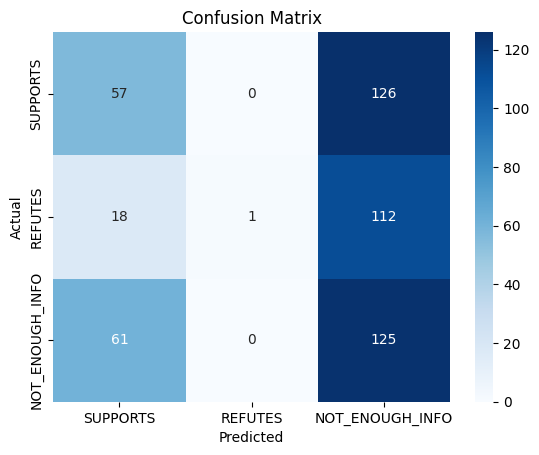

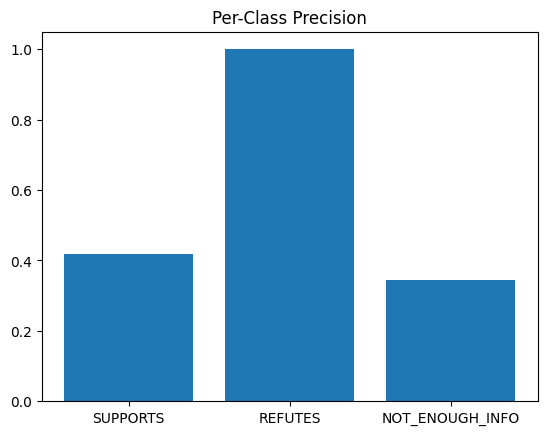

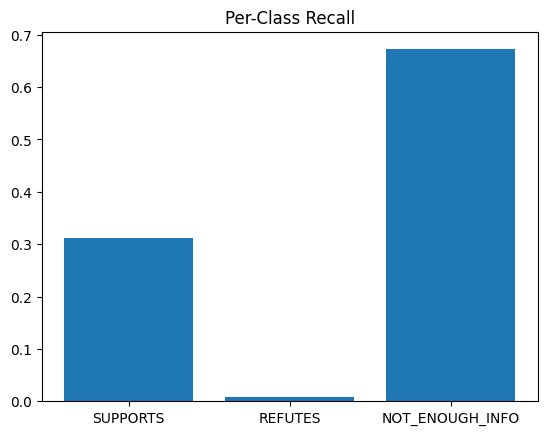

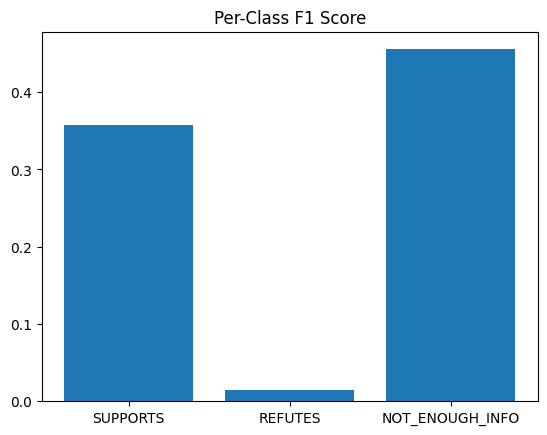

In [15]:
validate(data[:500], model, tokenizer, "Evaluating PubMed+KG with SFT Model without Chain-of-Thought", use_pubmed=True, use_kg=True, use_cot=False, use_ift=False)

Evaluating PubMed+KG with SFT Model without Chain-of-Thought:   0%|          | 0/20 [00:00<?, ?it/s]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model without Chain-of-Thought:   5%|▌         | 1/20 [00:15<04:47, 15.11s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  10%|█         | 2/20 [00:19<02:35,  8.64s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  15%|█▌        | 3/20 [00:30<02:50, 10.01s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  20%|██        | 4/20 [00:36<02:14,  8.38s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  25%|██▌       | 5/20 [01:11<04:29, 17.98s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  30%|███       | 6/20 [01:35<04:36, 19.78s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  35%|███▌      | 7/20 [01:39<03:12, 14.83s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  40%|████      | 8/20 [01:46<02:27, 12.31s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model without Chain-of-Thought:  45%|██


📊 Results:
Accuracy: 0.3500
Macro F1: 0.2583
Macro Precision: 0.2889
Macro Recall: 0.3576
Prediction Distribution: Counter({'NOT_ENOUGH_INFO': 15, 'SUPPORTS': 5})
Ground Truth Distribution: Counter({'SUPPORTS': 11, 'NOT_ENOUGH_INFO': 5, 'REFUTES': 4})



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


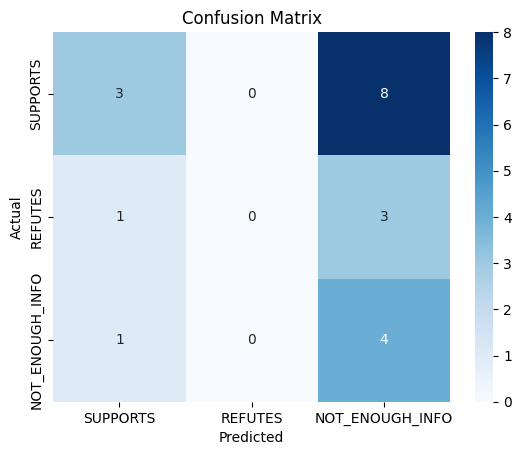

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


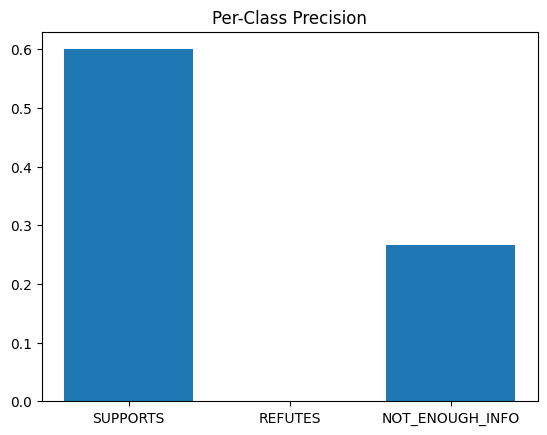

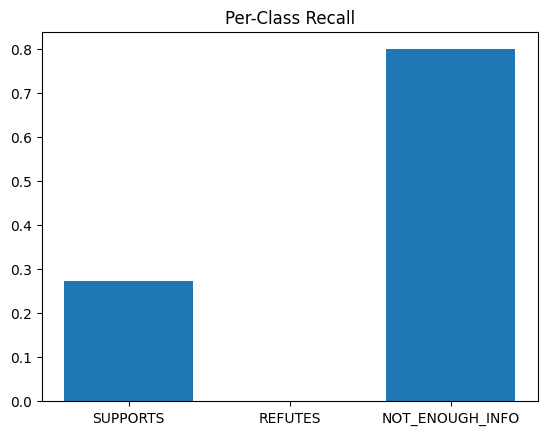

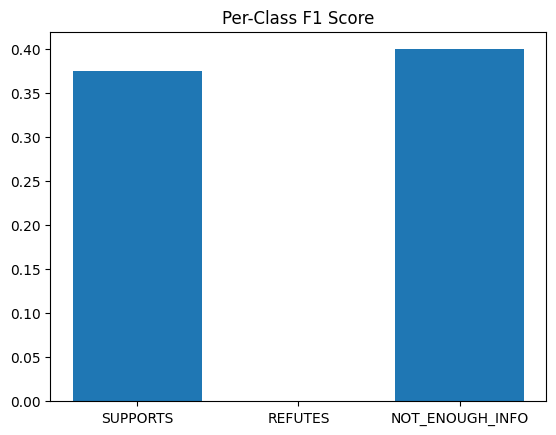

In [18]:
validate(data[:20], model, tokenizer, "Evaluating PubMed+KG with SFT Model without Chain-of-Thought", use_pubmed=True, use_kg=True, use_cot=False, use_ift=False)

Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   0%|          | 0/500 [00:00<?, ?it/s]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   0%|          | 1/500 [00:17<2:23:58, 17.31s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   0%|          | 2/500 [00:26<1:45:04, 12.66s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   1%|          | 3/500 [00:59<2:59:38, 21.69s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   1%|          | 4/500 [01:18<2:51:57, 20.80s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   1%|          | 5/500 [01:38<2:48:33, 20.43s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   1%|          | 6/500 [01:52<2:30:26, 18.27s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   1%|▏         | 7/500 [02:10<2:29:05, 18.15s/it]Device set to use cuda:0
Evaluating PubMed+KG w

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   4%|▍         | 21/500 [07:44<2:59:19, 22.46s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   4%|▍         | 22/500 [08:20<3:30:34, 26.43s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   5%|▍         | 23/500 [08:27<2:43:46, 20.60s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   5%|▍         | 24/500 [09:03<3:19:30, 25.15s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   5%|▌         | 25/500 [09:20<3:00:37, 22.82s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   5%|▌         | 26/500 [09:42<2:57:23, 22.45s/it]Device set to use cuda:0
Evaluating PubMe

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  17%|█▋        | 85/500 [32:56<2:41:25, 23.34s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  17%|█▋        | 86/500 [33:31<3:05:52, 26.94s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  17%|█▋        | 87/500 [33:46<2:41:01, 23.39s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  18%|█▊        | 88/500 [34:11<2:43:28, 23.81s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  18%|█▊        | 89/500 [34:36<2:45:31, 24.16s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  18%|█▊        | 90/500 [35:04<2:52:16, 25.21s/it]Device set to use cuda:0
Evaluating PubMe

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  19%|█▉        | 94/500 [36:18<2:18:37, 20.49s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  19%|█▉        | 95/500 [36:26<1:53:33, 16.82s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  19%|█▉        | 96/500 [36:41<1:49:48, 16.31s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  19%|█▉        | 97/500 [37:17<2:28:32, 22.12s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  20%|█▉        | 98/500 [37:49<2:48:42, 25.18s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  20%|█▉        | 99/500 [37:56<2:12:02, 19.76s/it]Device set to use cuda:0
Evaluating PubMe

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  23%|██▎       | 113/500 [42:51<1:59:37, 18.55s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  23%|██▎       | 114/500 [43:20<2:18:28, 21.52s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  23%|██▎       | 115/500 [43:36<2:08:09, 19.97s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  23%|██▎       | 116/500 [43:47<1:51:20, 17.40s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  23%|██▎       | 117/500 [44:23<2:26:13, 22.91s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  24%|██▎       | 118/500 [44:45<2:24:14, 22.65s/it]Device set to use cuda:0
Evaluating

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  26%|██▌       | 131/500 [49:04<1:35:06, 15.47s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  26%|██▋       | 132/500 [49:32<1:58:29, 19.32s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  27%|██▋       | 133/500 [50:05<2:23:34, 23.47s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  27%|██▋       | 134/500 [50:39<2:41:50, 26.53s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  27%|██▋       | 135/500 [50:48<2:09:31, 21.29s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  27%|██▋       | 136/500 [51:15<2:18:40, 22.86s/it]Device set to use cuda:0
Evaluating

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  28%|██▊       | 141/500 [52:41<1:43:36, 17.32s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  28%|██▊       | 142/500 [52:59<1:45:44, 17.72s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  29%|██▊       | 143/500 [53:21<1:53:08, 19.02s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  29%|██▉       | 144/500 [53:44<1:59:30, 20.14s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  29%|██▉       | 145/500 [54:08<2:05:23, 21.19s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  29%|██▉       | 146/500 [54:23<1:55:11, 19.52s/it]Device set to use cuda:0
Evaluating

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  32%|███▏      | 159/500 [59:06<1:38:28, 17.33s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  32%|███▏      | 160/500 [59:31<1:50:32, 19.51s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  32%|███▏      | 161/500 [1:00:07<2:17:49, 24.39s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  32%|███▏      | 162/500 [1:00:43<2:36:29, 27.78s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  33%|███▎      | 163/500 [1:01:04<2:24:50, 25.79s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  33%|███▎      | 164/500 [1:01:25<2:17:26, 24.54s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  33%|███▎      | 165/500 [1:02:01<2:36:13, 27.98s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  33%|███▎      | 166/500 [1:02:37<2:48:17, 30.23s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  33%|███▎      | 167/500 [1:02:44<2:09:30, 23.34s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  34%|███▎      | 168/500 [1:03:20<2:29:28, 27.01s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  34%|███▍      | 169/500 [1:03:55<2:43:22, 29.62s/it]Device set to use cuda:

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  36%|███▌      | 179/500 [1:08:04<2:01:25, 22.69s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  36%|███▌      | 180/500 [1:08:39<2:21:32, 26.54s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  36%|███▌      | 181/500 [1:09:15<2:35:31, 29.25s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  36%|███▋      | 182/500 [1:09:37<2:24:35, 27.28s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  37%|███▋      | 183/500 [1:10:13<2:37:18, 29.78s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  37%|███▋      | 184/500 [1:10:49<2:46:22, 31.59s/it]Device set to use cuda:

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  44%|████▍     | 221/500 [1:25:58<1:29:12, 19.19s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  44%|████▍     | 222/500 [1:26:33<1:51:34, 24.08s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  45%|████▍     | 223/500 [1:26:52<1:44:13, 22.58s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  45%|████▍     | 224/500 [1:27:28<2:01:47, 26.48s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  45%|████▌     | 225/500 [1:27:51<1:56:44, 25.47s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  45%|████▌     | 226/500 [1:28:09<1:45:11, 23.04s/it]Device set to use cuda:

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  46%|████▌     | 230/500 [1:29:46<1:36:17, 21.40s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  46%|████▌     | 231/500 [1:29:57<1:22:02, 18.30s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  46%|████▋     | 232/500 [1:30:14<1:19:03, 17.70s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  47%|████▋     | 233/500 [1:30:38<1:28:00, 19.78s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  47%|████▋     | 234/500 [1:31:14<1:48:30, 24.47s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  47%|████▋     | 235/500 [1:31:23<1:27:31, 19.82s/it]Device set to use cuda:

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  48%|████▊     | 238/500 [1:32:43<1:39:30, 22.79s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  48%|████▊     | 239/500 [1:33:18<1:55:41, 26.60s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  48%|████▊     | 240/500 [1:33:24<1:27:47, 20.26s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  48%|████▊     | 241/500 [1:33:39<1:21:19, 18.84s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  48%|████▊     | 242/500 [1:33:51<1:11:33, 16.64s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  49%|████▊     | 243/500 [1:34:27<1:35:39, 22.33s/it]Device set to use cuda:

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  49%|████▉     | 246/500 [1:35:17<1:17:25, 18.29s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  49%|████▉     | 247/500 [1:35:53<1:38:35, 23.38s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  50%|████▉     | 248/500 [1:36:30<1:55:16, 27.44s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  50%|████▉     | 249/500 [1:36:45<1:40:17, 23.97s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  50%|█████     | 250/500 [1:37:10<1:40:08, 24.03s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  50%|█████     | 251/500 [1:37:19<1:21:53, 19.73s/it]Device set to use cuda:

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  53%|█████▎    | 265/500 [1:43:11<1:27:47, 22.42s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  53%|█████▎    | 266/500 [1:43:46<1:42:45, 26.35s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  53%|█████▎    | 267/500 [1:44:22<1:52:58, 29.09s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  54%|█████▎    | 268/500 [1:44:58<2:00:22, 31.13s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  54%|█████▍    | 269/500 [1:45:29<2:00:38, 31.34s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  54%|█████▍    | 270/500 [1:45:36<1:32:06, 24.03s/it]Device set to use cuda:

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  55%|█████▍    | 274/500 [1:47:09<1:19:17, 21.05s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  55%|█████▌    | 275/500 [1:47:23<1:10:51, 18.89s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  55%|█████▌    | 276/500 [1:47:59<1:29:09, 23.88s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  55%|█████▌    | 277/500 [1:48:12<1:17:01, 20.72s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  56%|█████▌    | 278/500 [1:48:46<1:31:39, 24.77s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  56%|█████▌    | 279/500 [1:48:52<1:10:23, 19.11s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  56%|█████▌    | 280/500 [1:49:28<1:28:34, 24.15s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  56%|█████▌    | 281/500 [1:49:51<1:26:23, 23.67s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  56%|█████▋    | 282/500 [1:50:15<1:27:00, 23.95s/it]Device set to use cuda:

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  57%|█████▋    | 283/500 [1:50:30<1:17:03, 21.31s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  57%|█████▋    | 284/500 [1:51:06<1:32:04, 25.57s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  57%|█████▋    | 285/500 [1:51:41<1:42:17, 28.55s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  57%|█████▋    | 286/500 [1:51:57<1:27:35, 24.56s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  57%|█████▋    | 287/500 [1:52:19<1:24:19, 23.75s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  58%|█████▊    | 288/500 [1:52:54<1:36:32, 27.32s/it]Device set to use cuda:

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  62%|██████▏   | 309/500 [1:59:58<1:06:15, 20.82s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  62%|██████▏   | 310/500 [2:00:08<56:05, 17.71s/it]  Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  62%|██████▏   | 311/500 [2:00:13<43:29, 13.81s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  62%|██████▏   | 312/500 [2:00:28<44:28, 14.20s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  63%|██████▎   | 313/500 [2:01:04<1:04:08, 20.58s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  63%|██████▎   | 314/500 [2:01:23<1:02:47, 20.25s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  63%|██████▎   | 315/500 [2:01:51<1:09:17, 22.47s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  63%|██████▎   | 316/500 [2:02:08<1:04:13, 20.95s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  63%|██████▎   | 317/500 [2:02:35<1:09:45, 22.87s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  72%|███████▏  | 359/500 [2:17:20<44:55, 19.12s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  72%|███████▏  | 360/500 [2:17:38<44:12, 18.95s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  72%|███████▏  | 361/500 [2:18:14<55:20, 23.89s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  72%|███████▏  | 362/500 [2:18:24<45:26, 19.76s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  73%|███████▎  | 363/500 [2:18:38<41:27, 18.15s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  73%|███████▎  | 364/500 [2:18:48<35:14, 15.55s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  73%|███████▎  | 365/500 [2:19:02<34:30, 15.34s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  73%|███████▎  | 366/500 [2:19:08<27:41, 12.40s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  73%|███████▎  | 367/500 [2:19:26<31:10, 14.06s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  74%|███████▎  | 368/500 [2:19:55<40:37, 18.47s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  74%|███████▍  | 369/500 [2:20:18<43:28, 19.91s/it]Device set to use cuda:0
Evaluating

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  75%|███████▍  | 373/500 [2:21:27<33:59, 16.06s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  75%|███████▍  | 374/500 [2:21:36<29:01, 13.82s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  75%|███████▌  | 375/500 [2:21:53<31:02, 14.90s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  75%|███████▌  | 376/500 [2:21:59<25:15, 12.23s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  75%|███████▌  | 377/500 [2:22:25<33:47, 16.48s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  76%|███████▌  | 378/500 [2:22:31<26:54, 13.23s/it]Device set to use cuda:0
Evaluating

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  77%|███████▋  | 383/500 [2:24:34<35:19, 18.12s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  77%|███████▋  | 384/500 [2:24:48<32:21, 16.74s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  77%|███████▋  | 385/500 [2:25:01<30:05, 15.70s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  77%|███████▋  | 386/500 [2:25:19<30:47, 16.21s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  77%|███████▋  | 387/500 [2:25:55<41:38, 22.11s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  78%|███████▊  | 388/500 [2:26:12<38:35, 20.67s/it]Device set to use cuda:0
Evaluating

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  82%|████████▏ | 410/500 [2:33:38<21:52, 14.59s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  82%|████████▏ | 411/500 [2:33:44<17:40, 11.92s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  82%|████████▏ | 412/500 [2:33:56<17:25, 11.88s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  83%|████████▎ | 413/500 [2:34:31<27:32, 18.99s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  83%|████████▎ | 414/500 [2:35:07<34:27, 24.04s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  83%|████████▎ | 415/500 [2:35:36<36:10, 25.53s/it]Device set to use cuda:0
Evaluating

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  88%|████████▊ | 441/500 [2:46:34<26:00, 26.45s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  88%|████████▊ | 442/500 [2:47:04<26:26, 27.36s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  89%|████████▊ | 443/500 [2:47:31<25:57, 27.33s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  89%|████████▉ | 444/500 [2:48:06<27:46, 29.76s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  89%|████████▉ | 445/500 [2:48:28<25:05, 27.38s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  89%|████████▉ | 446/500 [2:49:04<26:47, 29.77s/it]Device set to use cuda:0
Evaluating

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  92%|█████████▏| 458/500 [2:54:24<16:21, 23.38s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  92%|█████████▏| 459/500 [2:55:00<18:27, 27.02s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  92%|█████████▏| 460/500 [2:55:17<16:02, 24.05s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  92%|█████████▏| 461/500 [2:55:27<12:58, 19.97s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  92%|█████████▏| 462/500 [2:55:33<10:01, 15.84s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  93%|█████████▎| 463/500 [2:56:09<13:24, 21.73s/it]Device set to use cuda:0
Evaluating

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  94%|█████████▎| 468/500 [2:58:07<12:29, 23.41s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  94%|█████████▍| 469/500 [2:58:18<10:11, 19.71s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  94%|█████████▍| 470/500 [2:58:54<12:13, 24.45s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  94%|█████████▍| 471/500 [2:59:30<13:26, 27.81s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  94%|█████████▍| 472/500 [2:59:55<12:38, 27.09s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  95%|█████████▍| 473/500 [3:00:30<13:19, 29.60s/it]Device set to use cuda:0
Evaluating

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  96%|█████████▌| 478/500 [3:02:32<09:27, 25.80s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  96%|█████████▌| 479/500 [3:02:50<08:09, 23.29s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  96%|█████████▌| 480/500 [3:03:07<07:10, 21.51s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  96%|█████████▌| 481/500 [3:03:42<08:08, 25.71s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  96%|█████████▋| 482/500 [3:04:18<08:34, 28.61s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  97%|█████████▋| 483/500 [3:04:35<07:08, 25.23s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  97%|█████████▋| 484/500 [3:04:45<05:27, 20.48s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  97%|█████████▋| 485/500 [3:05:00<04:45, 19.04s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  97%|█████████▋| 486/500 [3:05:14<04:05, 17.50s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  97%|█████████▋| 487/500 [3:05:47<04:48, 22.19s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  98%|█████████▊| 488/500 [3:06:23<05:15, 26.30s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  98%|█████████▊| 489/500 [3:06:52<04:56, 26.98s/it]Device set to use cuda:0
Evaluating


📊 Results:
Accuracy: 0.3875
Macro F1: 0.3208
Macro Precision: 0.3609
Macro Recall: 0.3579
Prediction Distribution: Counter({'NOT_ENOUGH_INFO': 214, 'SUPPORTS': 172, 'REFUTES': 14})
Ground Truth Distribution: Counter({'SUPPORTS': 149, 'NOT_ENOUGH_INFO': 142, 'REFUTES': 109})


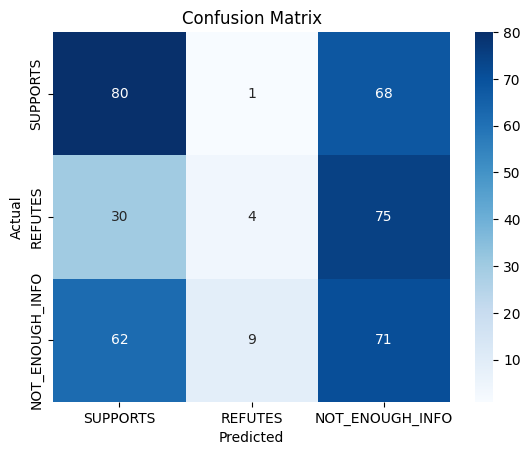

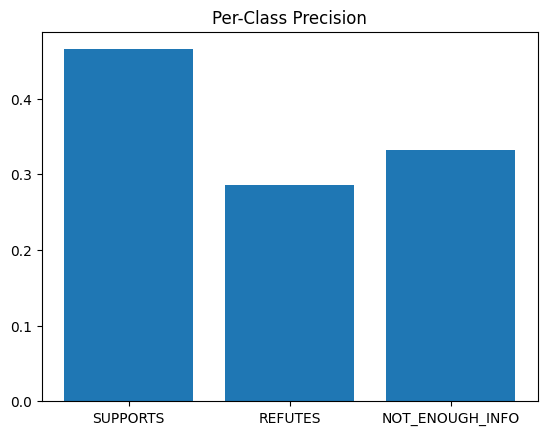

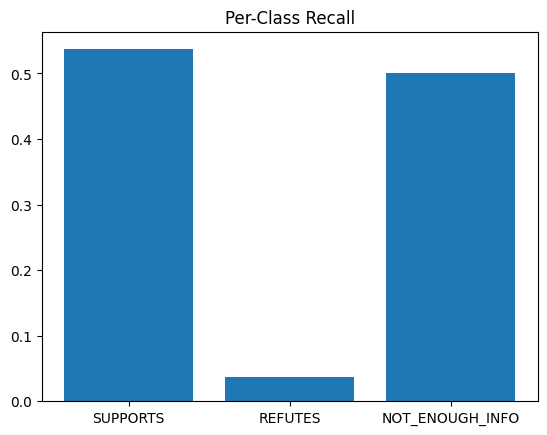

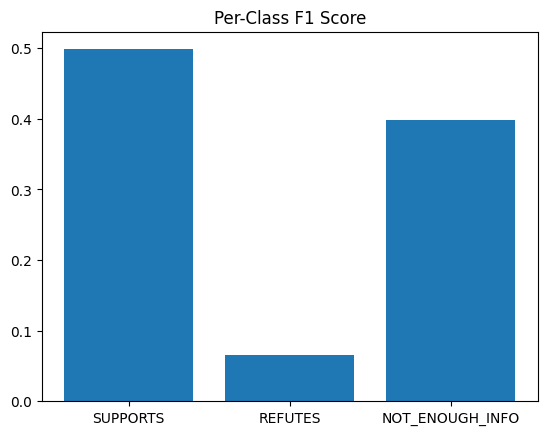

In [23]:
validate(data[:500], model, tokenizer, "Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning", use_pubmed=True, use_kg=True, use_cot=True, use_ift=True)

Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   0%|          | 0/30 [00:00<?, ?it/s]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   3%|▎         | 1/30 [00:16<08:10, 16.92s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   7%|▋         | 2/30 [00:26<05:48, 12.45s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  10%|█         | 3/30 [00:58<09:35, 21.30s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  13%|█▎        | 4/30 [01:17<08:52, 20.50s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  17%|█▋        | 5/30 [01:37<08:25, 20.20s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  20%|██        | 6/30 [01:51<07:14, 18.11s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  23%|██▎       | 7/30 [02:09<06:57, 18.13s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  70%|███████   | 21/30 [07:42<03:22, 22.45s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  73%|███████▎  | 22/30 [08:18<03:30, 26.33s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  77%|███████▋  | 23/30 [08:25<02:23, 20.53s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  80%|████████  | 24/30 [09:01<02:30, 25.08s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  83%|████████▎ | 25/30 [09:17<01:53, 22.61s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  87%|████████▋ | 26/30 [09:39<01:29, 22.36s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Mode


📊 Results:
Accuracy: 0.5769
Macro F1: 0.4902
Macro Precision: 0.6889
Macro Recall: 0.5024
Prediction Distribution: Counter({'SUPPORTS': 15, 'NOT_ENOUGH_INFO': 10, 'REFUTES': 1})
Ground Truth Distribution: Counter({'SUPPORTS': 13, 'NOT_ENOUGH_INFO': 7, 'REFUTES': 6})


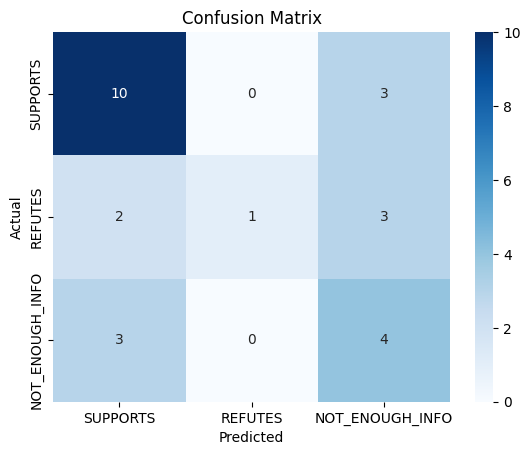

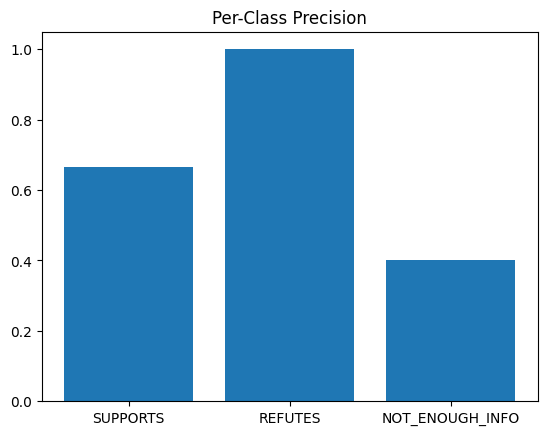

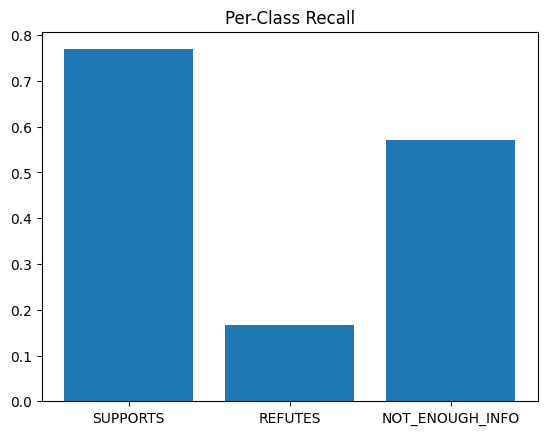

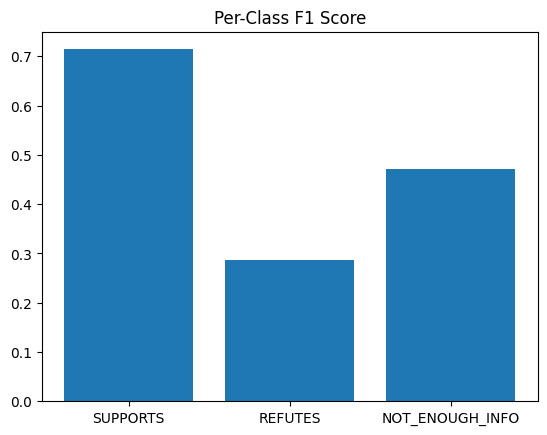

In [24]:
validate(data[:30], model, tokenizer, "Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning", use_pubmed=True, use_kg=True, use_cot=True, use_ift=True)

Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   0%|          | 0/50 [00:00<?, ?it/s]Device set to use cuda:0
Token indices sequence length is longer than the specified maximum sequence length for this model (1028 > 520). Running this sequence through the model will result in indexing errors
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   2%|▏         | 1/50 [00:22<18:16, 22.37s/it]Device set to use cuda:0


No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   4%|▍         | 2/50 [00:31<11:40, 14.60s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   6%|▌         | 3/50 [01:03<17:34, 22.43s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:   8%|▊         | 4/50 [01:22<16:14, 21.19s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  10%|█         | 5/50 [01:43<15:43, 20.97s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  12%|█▏        | 6/50 [02:01<14:36, 19.93s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  14%|█▍        | 7/50 [02:18<13:48, 19.26s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with

No PMIDs found for that query.
No abstracts found.


Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  42%|████▏     | 21/50 [07:58<10:58, 22.71s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  44%|████▍     | 22/50 [08:34<12:26, 26.65s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  46%|████▌     | 23/50 [08:41<09:25, 20.93s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  48%|████▊     | 24/50 [09:19<11:15, 25.98s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  50%|█████     | 25/50 [09:36<09:42, 23.30s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning:  52%|█████▏    | 26/50 [09:57<09:03, 22.67s/it]Device set to use cuda:0
Evaluating PubMed+KG with SFT Mode


📊 Results:
Accuracy: 0.5116
Macro F1: 0.4333
Macro Precision: 0.5193
Macro Recall: 0.4543
Prediction Distribution: Counter({'NOT_ENOUGH_INFO': 23, 'SUPPORTS': 18, 'REFUTES': 2})
Ground Truth Distribution: Counter({'SUPPORTS': 22, 'NOT_ENOUGH_INFO': 13, 'REFUTES': 8})


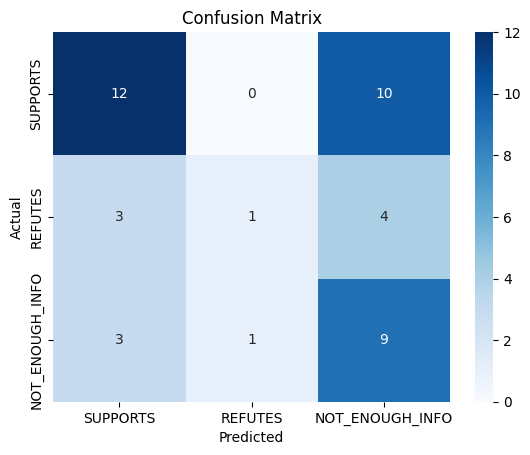

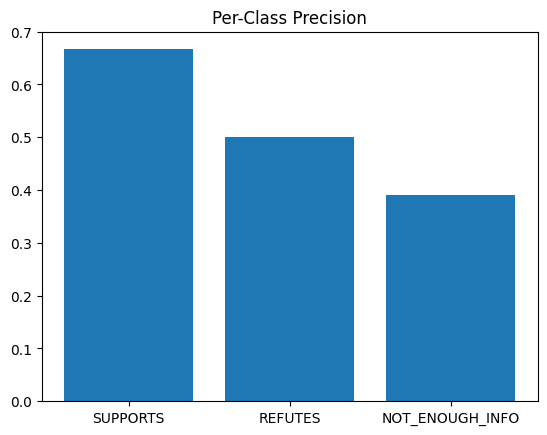

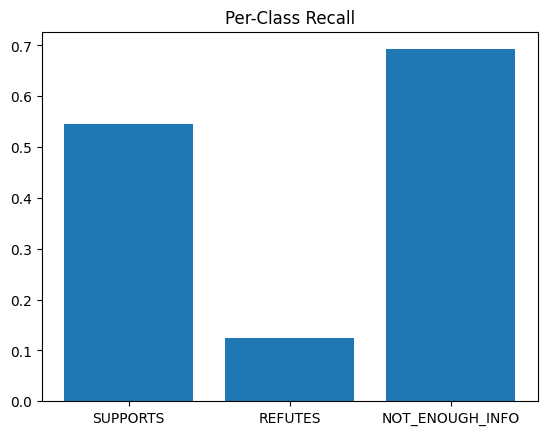

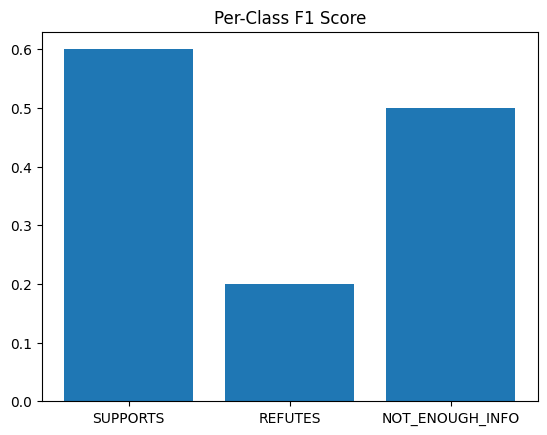

In [17]:
validate(data[:50], model, tokenizer, "Evaluating PubMed+KG with SFT Model with Chain-of-Thought and Instruction Prompt Tuning", use_pubmed=True, use_kg=True, use_cot=True, use_ift=True)